In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
import xgboost as xgb
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from category_encoders.cat_boost import CatBoostEncoder
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.2 MB/s eta 0:00:00


## training data

In [3]:
patient_df = pd.read_csv('target_train.csv')

In [4]:
medical_df = pd.read_csv('medclms_train.csv')

In [5]:
# drop duplicate claims
medical_df.drop(columns=['medclm_key','clm_unique_key'],inplace=True)
medical_df.drop_duplicates(inplace = True)

In [6]:
# calculate % of null-value in each column
medical_df.isna().sum()/medical_df.shape[0]

therapy_id                 0.000000
primary_diag_cd            0.000000
visit_date                 0.000000
diag_cd2                   0.302310
diag_cd3                   0.495988
diag_cd4                   0.624573
diag_cd5                   0.730951
diag_cd6                   0.783267
diag_cd7                   0.825014
diag_cd8                   0.853984
diag_cd9                   0.877864
process_date               0.000000
reversal_ind               0.986933
pot                        0.000000
util_cat                   0.543383
hedis_pot                  0.000000
clm_type                   0.000000
ade_diagnosis              0.000000
seizure_diagnosis          0.000000
pain_diagnosis             0.000000
fatigue_diagnosis          0.000000
nausea_diagnosis           0.000000
hyperglycemia_diagnosis    0.000000
constipation_diagnosis     0.000000
diarrhea_diagnosis         0.000000
dtype: float64

In [7]:
# drop columns with 60% of null-value
medical_df.drop(columns=['diag_cd4','diag_cd5','diag_cd6','diag_cd7',
                         'diag_cd8','diag_cd9','reversal_ind'],inplace=True)

In [8]:
time_df = patient_df[['therapy_id','therapy_start_date']]
time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)
medical_df = medical_df.merge(time_df, how='left', on='therapy_id')
medical_df.visit_date = pd.to_datetime(medical_df.visit_date)

<ipython-input-8-06dea78dc2db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)


In [9]:
medical_df['time_diff'] = (medical_df.visit_date-medical_df.therapy_start_date).dt.total_seconds() / 3600
medical_df = medical_df[medical_df['time_diff']>0]

In [10]:
# drop irrevalant columns
medical_df.drop(columns=['visit_date','process_date','time_diff','therapy_start_date'],inplace=True)

In [11]:
# medical_df['therapy_id'].value_counts()

In [12]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16855 entries, 1 to 41248
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   therapy_id               16855 non-null  object
 1   primary_diag_cd          16855 non-null  object
 2   diag_cd2                 12014 non-null  object
 3   diag_cd3                 8773 non-null   object
 4   pot                      16855 non-null  object
 5   util_cat                 8087 non-null   object
 6   hedis_pot                16855 non-null  object
 7   clm_type                 16855 non-null  object
 8   ade_diagnosis            16855 non-null  int64 
 9   seizure_diagnosis        16855 non-null  int64 
 10  pain_diagnosis           16855 non-null  int64 
 11  fatigue_diagnosis        16855 non-null  int64 
 12  nausea_diagnosis         16855 non-null  int64 
 13  hyperglycemia_diagnosis  16855 non-null  int64 
 14  constipation_diagnosis   16855 non-nul

In [13]:
medical_df.fillna("Missing",inplace=True)

In [14]:
# get top 10 value in 'primary_diag_cd' and change others to 'other'
# top_values = medical_df['primary_diag_cd'].value_counts().index[:11]
# medical_df.loc[~medical_df['primary_diag_cd'].isin(top_values), 'primary_diag_cd'] = 'Other'
# medical_df.loc[~medical_df['diag_cd2'].isin(top_values), 'diag_cd2'] = 'Other'
# medical_df.loc[~medical_df['diag_cd3'].isin(top_values), 'diag_cd3'] = 'Other'


In [15]:
# Define a custom function to determine the most frequent non-"other" string
def most_frequent_non_missing(group):
    non_missing_values = group[group != 'Missing']
    if non_missing_values.empty:
        return 'Missing'
    else:
        return non_missing_values.mode().iloc[0]

def most_frequent_non_unknown(group):
    non_unknown_values = group[group != 'Unknown']
    if non_unknown_values.empty:
        return 'Unknown'
    else:
        return non_unknown_values.mode().iloc[0]

# def most_frequent_non_null(group):
#     non_null_values = group[group.notnull()]
#     if non_null_values.empty:
#         return 'null'
#     else:
#         return non_null_values.mode().iloc[0]

def most_frequent_non_other(group):
    non_other_values = group[group != 'Other']
    if non_other_values.empty:
        return 'Other'
    else:
        return non_other_values.mode().iloc[0]

# Group by 'id' and apply the custom function
result1 = medical_df.groupby('therapy_id')['primary_diag_cd'].agg(most_frequent_non_missing).reset_index()
result2 = medical_df.groupby('therapy_id')['diag_cd2'].agg(most_frequent_non_missing).reset_index()
result3 = medical_df.groupby('therapy_id')['diag_cd3'].agg(most_frequent_non_missing).reset_index()
result4 = medical_df.groupby('therapy_id')['pot'].agg(most_frequent_non_unknown).reset_index()
result5 = medical_df.groupby('therapy_id')['util_cat'].agg(most_frequent_non_missing).reset_index()
result6 = medical_df.groupby('therapy_id')['hedis_pot'].agg(most_frequent_non_other).reset_index()

In [16]:
diagnosis_ind = medical_df.groupby('therapy_id').agg(lambda x: (x == 1).any()).reset_index()
to_process = medical_df.columns[8:]
diagnosis_ind[to_process] = diagnosis_ind[to_process].astype(int)
cols = range(1,8)
diagnosis_ind.drop(diagnosis_ind.columns[cols], axis=1, inplace=True)

In [17]:
final_medical_df = diagnosis_ind.merge(result1, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result2, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result3, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result4, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result5, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result6, on='therapy_id', how='left')

In [18]:
agg_count = medical_df.groupby('therapy_id').size().reset_index(name='med_count')
label_df = patient_df[['therapy_id','tgt_ade_dc_ind']]

final_medical_df = final_medical_df.merge(agg_count, how='left', on='therapy_id')
final_medical_df = final_medical_df.merge(label_df, how='left', on='therapy_id')

In [19]:
# final_medical_df.loc[:, final_medical_df.dtypes == 'object'] =\
#     final_medical_df.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

In [20]:
final_medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 515
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   therapy_id               516 non-null    object
 1   ade_diagnosis            516 non-null    int64 
 2   seizure_diagnosis        516 non-null    int64 
 3   pain_diagnosis           516 non-null    int64 
 4   fatigue_diagnosis        516 non-null    int64 
 5   nausea_diagnosis         516 non-null    int64 
 6   hyperglycemia_diagnosis  516 non-null    int64 
 7   constipation_diagnosis   516 non-null    int64 
 8   diarrhea_diagnosis       516 non-null    int64 
 9   primary_diag_cd          516 non-null    object
 10  diag_cd2                 516 non-null    object
 11  diag_cd3                 516 non-null    object
 12  pot                      516 non-null    object
 13  util_cat                 516 non-null    object
 14  hedis_pot                516 non-null    o

In [21]:
# X = final_medical_df.drop(columns = ['therapy_id','tgt_ade_dc_ind'])
# y = final_medical_df['tgt_ade_dc_ind']
# # fit model no training data
# model = xgb.XGBClassifier(enable_categorical = True)
# model.fit(X, y)
# # feature importance
# print(model.feature_importances_)
# # plot
# xgb.plot_importance(model)
# plt.show()

In [22]:
pharmacy_df = pd.read_csv('rxclms_train.csv')

In [23]:
# drop duplicate claims
pharmacy_df.drop(columns=['document_key','ndc_id'],inplace=True)
pharmacy_df.drop_duplicates(inplace = True)

In [24]:
# calculate % of null-value in each column
pharmacy_df.isna().sum()/pharmacy_df.shape[0]

therapy_id                 0.000000
service_date               0.000000
process_date               0.000000
pay_day_supply_cnt         0.000000
rx_cost                    0.000000
tot_drug_cost_accum_amt    0.000000
reversal_ind               0.000000
mail_order_ind             0.000000
generic_ind                0.000000
maint_ind                  0.000000
gpi_drug_group_desc        0.050232
gpi_drug_class_desc        0.050232
hum_drug_class_desc        0.050232
strength_meas              0.058055
metric_strength            0.058055
specialty_ind              0.000000
clm_type                   0.000000
ddi_ind                    0.000000
anticoag_ind               0.000000
diarrhea_treat_ind         0.000000
nausea_treat_ind           0.000000
seizure_treat_ind          0.000000
dtype: float64

In [25]:
time_df = patient_df[['therapy_id','therapy_start_date']]
time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)
pharmacy_df = pharmacy_df.merge(time_df, how='left', on='therapy_id')
pharmacy_df.service_date = pd.to_datetime(pharmacy_df.service_date)

<ipython-input-25-23d49b7669b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)


In [26]:
pharmacy_df['time_diff'] = (pharmacy_df.service_date-pharmacy_df.therapy_start_date).dt.total_seconds() / 3600
pharmacy_df = pharmacy_df[pharmacy_df['time_diff']>0]

In [27]:
# drop irrevalant columns
pharmacy_df.drop(columns=['service_date','process_date','reversal_ind','mail_order_ind',
                          'gpi_drug_group_desc','gpi_drug_class_desc','strength_meas',
                          'time_diff','therapy_start_date'],inplace=True)
pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19397 entries, 96 to 31831
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               19397 non-null  object 
 1   pay_day_supply_cnt       19397 non-null  int64  
 2   rx_cost                  19397 non-null  float64
 3   tot_drug_cost_accum_amt  19397 non-null  float64
 4   generic_ind              19397 non-null  object 
 5   maint_ind                19397 non-null  object 
 6   hum_drug_class_desc      18348 non-null  object 
 7   metric_strength          18200 non-null  float64
 8   specialty_ind            19397 non-null  object 
 9   clm_type                 19397 non-null  object 
 10  ddi_ind                  19397 non-null  int64  
 11  anticoag_ind             19397 non-null  int64  
 12  diarrhea_treat_ind       19397 non-null  int64  
 13  nausea_treat_ind         19397 non-null  int64  
 14  seizure_treat_ind    

<ipython-input-27-e53257ce9899>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacy_df.drop(columns=['service_date','process_date','reversal_ind','mail_order_ind',


In [28]:
pharmacy_df.hum_drug_class_desc.fillna("Missing",inplace=True)
# get top 10 value in 'hum_drug_class' and change others to 'other'
# top_values = pharmacy_df['hum_drug_class_desc'].value_counts().index[:11]
# pharmacy_df.loc[~pharmacy_df['hum_drug_class_desc'].isin(top_values), 'hum_drug_class_desc'] = 'Other'

<ipython-input-28-14b0d0f71c0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacy_df.hum_drug_class_desc.fillna("Missing",inplace=True)


In [29]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(pharmacy_df.metric_strength.to_numpy().reshape(-1, 1))
pharmacy_df.metric_strength = imputed
pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19397 entries, 96 to 31831
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               19397 non-null  object 
 1   pay_day_supply_cnt       19397 non-null  int64  
 2   rx_cost                  19397 non-null  float64
 3   tot_drug_cost_accum_amt  19397 non-null  float64
 4   generic_ind              19397 non-null  object 
 5   maint_ind                19397 non-null  object 
 6   hum_drug_class_desc      19397 non-null  object 
 7   metric_strength          19397 non-null  float64
 8   specialty_ind            19397 non-null  object 
 9   clm_type                 19397 non-null  object 
 10  ddi_ind                  19397 non-null  int64  
 11  anticoag_ind             19397 non-null  int64  
 12  diarrhea_treat_ind       19397 non-null  int64  
 13  nausea_treat_ind         19397 non-null  int64  
 14  seizure_treat_ind    

In [30]:
# multiple records of 'pay_day_supply_cnt', 'rx_cost', 'tot_drug_cost_accum_amt' and 'metric_strength' to one record

treat_ind = pharmacy_df.groupby('therapy_id').agg(lambda x: (x == 1).any()).reset_index()

to_process_pharmacy = pharmacy_df.columns[-5:]
treat_ind[to_process_pharmacy] = treat_ind[to_process_pharmacy].astype(int)
cols = range(1,10)
treat_ind.drop(treat_ind.columns[cols], axis=1, inplace=True)
avg_cost_df = pharmacy_df.groupby('therapy_id').agg({'pay_day_supply_cnt':'mean',
                                                     'rx_cost': 'mean',
                                                     'tot_drug_cost_accum_amt':'mean',
                                                     'metric_strength':'mean'}).reset_index()

avg_cost_df.columns = ['therapy_id', 'avg_supply_cnt','avg_rx_cost', 'avg_tot_cost','avg_metric_strength']


In [31]:
# Define a custom function to determine the most frequent non-"other" string

# Group by 'id' and apply the custom function
result1 = pharmacy_df.groupby('therapy_id')['generic_ind'].agg(most_frequent_non_missing).reset_index()
result2 = pharmacy_df.groupby('therapy_id')['maint_ind'].agg(most_frequent_non_missing).reset_index()
result3 = pharmacy_df.groupby('therapy_id')['hum_drug_class_desc'].agg(most_frequent_non_missing).reset_index()
result4 = pharmacy_df.groupby('therapy_id')['specialty_ind'].agg(most_frequent_non_missing).reset_index()

In [32]:
final_pharmacy_df = treat_ind.merge(avg_cost_df, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result1, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result2, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result3, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result4, on='therapy_id', how='left')

In [33]:
agg_count = pharmacy_df.groupby('therapy_id').size().reset_index(name='rx_count')
label_df = patient_df[['therapy_id','tgt_ade_dc_ind']]

final_pharmacy_df = final_pharmacy_df.merge(agg_count, how='left', on='therapy_id')
final_pharmacy_df = final_pharmacy_df.merge(label_df, how='left', on='therapy_id')

In [34]:
# final_pharmacy_df.loc[:, final_pharmacy_df.dtypes == 'object'] =\
#     final_pharmacy_df.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

In [35]:
final_pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073 entries, 0 to 1072
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   therapy_id           1073 non-null   object 
 1   ddi_ind              1073 non-null   int64  
 2   anticoag_ind         1073 non-null   int64  
 3   diarrhea_treat_ind   1073 non-null   int64  
 4   nausea_treat_ind     1073 non-null   int64  
 5   seizure_treat_ind    1073 non-null   int64  
 6   avg_supply_cnt       1073 non-null   float64
 7   avg_rx_cost          1073 non-null   float64
 8   avg_tot_cost         1073 non-null   float64
 9   avg_metric_strength  1073 non-null   float64
 10  generic_ind          1073 non-null   object 
 11  maint_ind            1073 non-null   object 
 12  hum_drug_class_desc  1073 non-null   object 
 13  specialty_ind        1073 non-null   object 
 14  rx_count             1073 non-null   int64  
 15  tgt_ade_dc_ind       1073 non-null   i

In [36]:
# X = final_pharmacy_df.drop(columns = ['therapy_id','tgt_ade_dc_ind'])
# y = final_pharmacy_df['tgt_ade_dc_ind']
# # fit model no training data
# model = xgb.XGBClassifier(enable_categorical = True)
# model.fit(X, y)
# # feature importance
# print(model.feature_importances_)
# # plot
# xgb.plot_importance(model)
# plt.show()

In [37]:
final_medical_df = final_medical_df.iloc[:,:-1]
final_pharmacy_df = final_pharmacy_df.iloc[:,:-1]

In [38]:
final_df = patient_df.merge(final_medical_df, on='therapy_id', how='left')
final_df = final_df.merge(final_pharmacy_df, on='therapy_id', how='left')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1231
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1232 non-null   int64  
 1   therapy_id               1232 non-null   object 
 2   therapy_start_date       1232 non-null   object 
 3   therapy_end_date         1232 non-null   object 
 4   tgt_ade_dc_ind           1232 non-null   int64  
 5   race_cd                  1164 non-null   float64
 6   est_age                  1149 non-null   float64
 7   sex_cd                   1149 non-null   object 
 8   cms_disabled_ind         1149 non-null   float64
 9   cms_low_income_ind       1149 non-null   float64
 10  ade_diagnosis            516 non-null    float64
 11  seizure_diagnosis        516 non-null    float64
 12  pain_diagnosis           516 non-null    float64
 13  fatigue_diagnosis        516 non-null    float64
 14  nausea_diagnosis        

In [39]:
final_df['ground_truth'] = final_df['tgt_ade_dc_ind']

# final_df.drop(columns = ['therapy_end_date','tgt_ade_dc_ind', 'id', 'therapy_id',
#                               'therapy_start_date', 'sex_cd', 'race_cd'], axis=1, inplace=True)

columns_to_fill = ['med_count','rx_count']
# Fill NA values with zero in the selected columns by index
final_df.loc[:, columns_to_fill] = final_df.loc[:, columns_to_fill].fillna(0)

In [40]:
lazy_people_train = final_df[(final_df.med_count == 0) & (final_df.rx_count == 0)]
filtered_data = final_df[(final_df.med_count > 0) | (final_df.rx_count > 0)]

filtered_data.drop(columns = ['therapy_end_date','tgt_ade_dc_ind', 'id', 'therapy_id',
                               'therapy_start_date', 'sex_cd', 'race_cd'], axis=1, inplace=True)

<ipython-input-40-410bf01c6f02>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns = ['therapy_end_date','tgt_ade_dc_ind', 'id', 'therapy_id',


In [41]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1103 entries, 0 to 1231
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  1091 non-null   float64
 1   cms_disabled_ind         1091 non-null   float64
 2   cms_low_income_ind       1091 non-null   float64
 3   ade_diagnosis            516 non-null    float64
 4   seizure_diagnosis        516 non-null    float64
 5   pain_diagnosis           516 non-null    float64
 6   fatigue_diagnosis        516 non-null    float64
 7   nausea_diagnosis         516 non-null    float64
 8   hyperglycemia_diagnosis  516 non-null    float64
 9   constipation_diagnosis   516 non-null    float64
 10  diarrhea_diagnosis       516 non-null    float64
 11  primary_diag_cd          516 non-null    object 
 12  diag_cd2                 516 non-null    object 
 13  diag_cd3                 516 non-null    object 
 14  pot                     

In [42]:
columns_to_fill = [1,2] + [i for i in range(3,11)] + [i for i in range(18,27)]
# Fill NA values with zero in the selected columns by index
filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna(0)

columns_to_fill = [i for i in range(11,17)] + [i for i in range(27,31)]
# Fill NA values with missing in the selected columns by index
filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna('Missing')

median_value = filtered_data['est_age'].median()  # Calculate the median for the column
filtered_data['est_age'] = filtered_data['est_age'].fillna(median_value)
train_df = filtered_data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1103 entries, 0 to 1231
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  1103 non-null   float64
 1   cms_disabled_ind         1103 non-null   float64
 2   cms_low_income_ind       1103 non-null   float64
 3   ade_diagnosis            1103 non-null   float64
 4   seizure_diagnosis        1103 non-null   float64
 5   pain_diagnosis           1103 non-null   float64
 6   fatigue_diagnosis        1103 non-null   float64
 7   nausea_diagnosis         1103 non-null   float64
 8   hyperglycemia_diagnosis  1103 non-null   float64
 9   constipation_diagnosis   1103 non-null   float64
 10  diarrhea_diagnosis       1103 non-null   float64
 11  primary_diag_cd          1103 non-null   object 
 12  diag_cd2                 1103 non-null   object 
 13  diag_cd3                 1103 non-null   object 
 14  pot                     

<ipython-input-42-a5be521be0fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna(0)
<ipython-input-42-a5be521be0fc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna('Missing')
<ipython-input-42-a5be521be0fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [43]:
train_df

,est_age,cms_disabled_ind,cms_low_income_ind,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,...,avg_supply_cnt,avg_rx_cost,avg_tot_cost,avg_metric_strength,generic_ind,maint_ind,hum_drug_class_desc,specialty_ind,rx_count,ground_truth
0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,28.214286,7276.783571,0.000000,91.428571,BRANDED,MAINT,ANTICONVULSANTS,NONSPCL,14.0,0
1,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.000000,8.215000,16327.565000,31.250000,GENERIC,MAINT,ANTICONVULSANTS,NONSPCL,4.0,1
2,79.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,11.007874,358.212835,65934.904016,74.787195,GENERIC,MAINT,CARDIOLOGY - HYPERTENSION AGENTS,NONSPCL,254.0,0
3,70.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.208955,1083.294328,50314.865821,1625.986270,GENERIC,MAINT,DIABETES,NONSPCL,67.0,0
4,74.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,51.254902,1462.124510,21795.655882,366.897536,BRANDED,NONMAINT,CARDIOLOGY - HYPERTENSION AGENTS,NONSPCL,51.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,91.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,29.916667,2772.497500,22002.131667,23.479167,GENERIC,NONMAINT,GASTROINTESTINAL DISEASE,NONSPCL,12.0,1
1228,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.419355,3636.060323,37245.561613,83.577419,GENERIC,NONMAINT,CHEMOTHERAPY,NONSPCL,31.0,0
1229,81.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.933333,5270.476667,57787.274000,127.333333,GENERIC,NONMAINT,CHEMOTHERAPY,NONSPCL,15.0,0
1230,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.500000,7.820000,15889.980000,3.000000,GENERIC,NONMAINT,STEROIDS,NONSPCL,2.0,0


## validation data

In [44]:
patient_df = pd.read_csv('target_holdout.csv')

In [45]:
medical_df = pd.read_csv('medclms_holdout.csv')

In [46]:
# drop duplicate claims
medical_df.drop(columns=['medclm_key','clm_unique_key'],inplace=True)
medical_df.drop_duplicates(inplace = True)

In [47]:
# calculate % of null-value in each column
medical_df.isna().sum()/medical_df.shape[0]

therapy_id                 0.000000
primary_diag_cd            0.000000
visit_date                 0.000000
diag_cd2                   0.314444
diag_cd3                   0.508327
diag_cd4                   0.643658
diag_cd5                   0.757411
diag_cd6                   0.810412
diag_cd7                   0.854928
diag_cd8                   0.881429
diag_cd9                   0.904263
process_date               0.000000
reversal_ind               0.991306
pot                        0.000000
util_cat                   0.541950
hedis_pot                  0.000000
clm_type                   0.000000
ade_diagnosis              0.000000
seizure_diagnosis          0.000000
pain_diagnosis             0.000000
fatigue_diagnosis          0.000000
nausea_diagnosis           0.000000
hyperglycemia_diagnosis    0.000000
constipation_diagnosis     0.000000
diarrhea_diagnosis         0.000000
dtype: float64

In [48]:
# drop columns with 60% of null-value
medical_df.drop(columns=['diag_cd4','diag_cd5','diag_cd6','diag_cd7',
                         'diag_cd8','diag_cd9','reversal_ind'],inplace=True)

In [49]:
time_df = patient_df[['therapy_id','therapy_start_date']]
time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)
medical_df = medical_df.merge(time_df, how='left', on='therapy_id')
medical_df.visit_date = pd.to_datetime(medical_df.visit_date)

<ipython-input-49-06dea78dc2db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)


In [50]:
medical_df['time_diff'] = (medical_df.visit_date-medical_df.therapy_start_date).dt.total_seconds() / 3600
medical_df = medical_df[medical_df['time_diff']>0]

In [51]:
# drop irrevalant columns
medical_df.drop(columns=['visit_date','process_date','time_diff','therapy_start_date'],inplace=True)

In [52]:
# medical_df['therapy_id'].value_counts()

In [53]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243 entries, 7 to 9546
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   therapy_id               2243 non-null   object
 1   primary_diag_cd          2243 non-null   object
 2   diag_cd2                 1532 non-null   object
 3   diag_cd3                 1122 non-null   object
 4   pot                      2243 non-null   object
 5   util_cat                 1128 non-null   object
 6   hedis_pot                2243 non-null   object
 7   clm_type                 2243 non-null   object
 8   ade_diagnosis            2243 non-null   int64 
 9   seizure_diagnosis        2243 non-null   int64 
 10  pain_diagnosis           2243 non-null   int64 
 11  fatigue_diagnosis        2243 non-null   int64 
 12  nausea_diagnosis         2243 non-null   int64 
 13  hyperglycemia_diagnosis  2243 non-null   int64 
 14  constipation_diagnosis   2243 non-null  

In [54]:
medical_df.fillna("Missing",inplace=True)

In [55]:
# get top 10 value in 'primary_diag_cd' and change others to 'other'
# top_values = medical_df['primary_diag_cd'].value_counts().index[:11]
# medical_df.loc[~medical_df['primary_diag_cd'].isin(top_values), 'primary_diag_cd'] = 'Other'
# medical_df.loc[~medical_df['diag_cd2'].isin(top_values), 'diag_cd2'] = 'Other'
# medical_df.loc[~medical_df['diag_cd3'].isin(top_values), 'diag_cd3'] = 'Other'


In [56]:
# Define a custom function to determine the most frequent non-"other" string
def most_frequent_non_missing(group):
    non_missing_values = group[group != 'Missing']
    if non_missing_values.empty:
        return 'Missing'
    else:
        return non_missing_values.mode().iloc[0]

def most_frequent_non_unknown(group):
    non_unknown_values = group[group != 'Unknown']
    if non_unknown_values.empty:
        return 'Unknown'
    else:
        return non_unknown_values.mode().iloc[0]

# def most_frequent_non_null(group):
#     non_null_values = group[group.notnull()]
#     if non_null_values.empty:
#         return 'null'
#     else:
#         return non_null_values.mode().iloc[0]

def most_frequent_non_other(group):
    non_other_values = group[group != 'Other']
    if non_other_values.empty:
        return 'Other'
    else:
        return non_other_values.mode().iloc[0]

# Group by 'id' and apply the custom function
result1 = medical_df.groupby('therapy_id')['primary_diag_cd'].agg(most_frequent_non_missing).reset_index()
result2 = medical_df.groupby('therapy_id')['diag_cd2'].agg(most_frequent_non_missing).reset_index()
result3 = medical_df.groupby('therapy_id')['diag_cd3'].agg(most_frequent_non_missing).reset_index()
result4 = medical_df.groupby('therapy_id')['pot'].agg(most_frequent_non_unknown).reset_index()
result5 = medical_df.groupby('therapy_id')['util_cat'].agg(most_frequent_non_missing).reset_index()
result6 = medical_df.groupby('therapy_id')['hedis_pot'].agg(most_frequent_non_other).reset_index()

In [57]:
diagnosis_ind = medical_df.groupby('therapy_id').agg(lambda x: (x == 1).any()).reset_index()
to_process = medical_df.columns[8:]
diagnosis_ind[to_process] = diagnosis_ind[to_process].astype(int)
cols = range(1,8)
diagnosis_ind.drop(diagnosis_ind.columns[cols], axis=1, inplace=True)

In [58]:
final_medical_df = diagnosis_ind.merge(result1, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result2, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result3, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result4, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result5, on='therapy_id', how='left')
final_medical_df = final_medical_df.merge(result6, on='therapy_id', how='left')

In [59]:
agg_count = medical_df.groupby('therapy_id').size().reset_index(name='med_count')

final_medical_df = final_medical_df.merge(agg_count, how='left', on='therapy_id')

In [60]:
# final_medical_df.loc[:, final_medical_df.dtypes == 'object'] =\
#     final_medical_df.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

In [61]:
final_medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 141
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   therapy_id               142 non-null    object
 1   ade_diagnosis            142 non-null    int64 
 2   seizure_diagnosis        142 non-null    int64 
 3   pain_diagnosis           142 non-null    int64 
 4   fatigue_diagnosis        142 non-null    int64 
 5   nausea_diagnosis         142 non-null    int64 
 6   hyperglycemia_diagnosis  142 non-null    int64 
 7   constipation_diagnosis   142 non-null    int64 
 8   diarrhea_diagnosis       142 non-null    int64 
 9   primary_diag_cd          142 non-null    object
 10  diag_cd2                 142 non-null    object
 11  diag_cd3                 142 non-null    object
 12  pot                      142 non-null    object
 13  util_cat                 142 non-null    object
 14  hedis_pot                142 non-null    o

In [62]:
# X = final_medical_df.drop(columns = ['therapy_id','tgt_ade_dc_ind'])
# y = final_medical_df['tgt_ade_dc_ind']
# # fit model no training data
# model = xgb.XGBClassifier(enable_categorical = True)
# model.fit(X, y)
# # feature importance
# print(model.feature_importances_)
# # plot
# xgb.plot_importance(model)
# plt.show()

In [63]:
pharmacy_df = pd.read_csv('rxclms_holdout.csv')

In [64]:
# drop duplicate claims
pharmacy_df.drop(columns=['document_key','ndc_id'],inplace=True)
pharmacy_df.drop_duplicates(inplace = True)

In [65]:
# calculate % of null-value in each column
pharmacy_df.isna().sum()/pharmacy_df.shape[0]

therapy_id                 0.000000
service_date               0.000000
process_date               0.000000
pay_day_supply_cnt         0.000000
rx_cost                    0.000000
tot_drug_cost_accum_amt    0.000000
reversal_ind               0.000000
mail_order_ind             0.000000
generic_ind                0.000000
maint_ind                  0.000000
gpi_drug_group_desc        0.053881
gpi_drug_class_desc        0.053881
hum_drug_class_desc        0.053881
strength_meas              0.062709
metric_strength            0.062709
specialty_ind              0.000000
clm_type                   0.000000
ddi_ind                    0.000000
anticoag_ind               0.000000
diarrhea_treat_ind         0.000000
nausea_treat_ind           0.000000
seizure_treat_ind          0.000000
dtype: float64

In [66]:
time_df = patient_df[['therapy_id','therapy_start_date']]
time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)
pharmacy_df = pharmacy_df.merge(time_df, how='left', on='therapy_id')
pharmacy_df.service_date = pd.to_datetime(pharmacy_df.service_date)

<ipython-input-66-23d49b7669b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.therapy_start_date = pd.to_datetime(time_df.therapy_start_date)


In [67]:
pharmacy_df['time_diff'] = (pharmacy_df.service_date-pharmacy_df.therapy_start_date).dt.total_seconds() / 3600
pharmacy_df = pharmacy_df[pharmacy_df['time_diff']>0]

In [68]:
# drop irrevalant columns
pharmacy_df.drop(columns=['service_date','process_date','reversal_ind','mail_order_ind',
                          'gpi_drug_group_desc','gpi_drug_class_desc','strength_meas',
                          'time_diff','therapy_start_date'],inplace=True)
pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799 entries, 36 to 6569
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               2799 non-null   object 
 1   pay_day_supply_cnt       2799 non-null   int64  
 2   rx_cost                  2799 non-null   float64
 3   tot_drug_cost_accum_amt  2799 non-null   float64
 4   generic_ind              2799 non-null   object 
 5   maint_ind                2799 non-null   object 
 6   hum_drug_class_desc      2604 non-null   object 
 7   metric_strength          2588 non-null   float64
 8   specialty_ind            2799 non-null   object 
 9   clm_type                 2799 non-null   object 
 10  ddi_ind                  2799 non-null   int64  
 11  anticoag_ind             2799 non-null   int64  
 12  diarrhea_treat_ind       2799 non-null   int64  
 13  nausea_treat_ind         2799 non-null   int64  
 14  seizure_treat_ind      

<ipython-input-68-e53257ce9899>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacy_df.drop(columns=['service_date','process_date','reversal_ind','mail_order_ind',


In [69]:
pharmacy_df.hum_drug_class_desc.fillna("Missing",inplace=True)
# get top 10 value in 'hum_drug_class' and change others to 'other'
# top_values = pharmacy_df['hum_drug_class_desc'].value_counts().index[:11]
# pharmacy_df.loc[~pharmacy_df['hum_drug_class_desc'].isin(top_values), 'hum_drug_class_desc'] = 'Other'

<ipython-input-69-14b0d0f71c0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacy_df.hum_drug_class_desc.fillna("Missing",inplace=True)


In [70]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(pharmacy_df.metric_strength.to_numpy().reshape(-1, 1))
pharmacy_df.metric_strength = imputed
pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799 entries, 36 to 6569
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   therapy_id               2799 non-null   object 
 1   pay_day_supply_cnt       2799 non-null   int64  
 2   rx_cost                  2799 non-null   float64
 3   tot_drug_cost_accum_amt  2799 non-null   float64
 4   generic_ind              2799 non-null   object 
 5   maint_ind                2799 non-null   object 
 6   hum_drug_class_desc      2799 non-null   object 
 7   metric_strength          2799 non-null   float64
 8   specialty_ind            2799 non-null   object 
 9   clm_type                 2799 non-null   object 
 10  ddi_ind                  2799 non-null   int64  
 11  anticoag_ind             2799 non-null   int64  
 12  diarrhea_treat_ind       2799 non-null   int64  
 13  nausea_treat_ind         2799 non-null   int64  
 14  seizure_treat_ind      

In [71]:
# multiple records of 'pay_day_supply_cnt', 'rx_cost', 'tot_drug_cost_accum_amt' and 'metric_strength' to one record

treat_ind = pharmacy_df.groupby('therapy_id').agg(lambda x: (x == 1).any()).reset_index()

to_process_pharmacy = pharmacy_df.columns[-5:]
treat_ind[to_process_pharmacy] = treat_ind[to_process_pharmacy].astype(int)
cols = range(1,10)
treat_ind.drop(treat_ind.columns[cols], axis=1, inplace=True)
avg_cost_df = pharmacy_df.groupby('therapy_id').agg({'pay_day_supply_cnt':'mean',
                                                     'rx_cost': 'mean',
                                                     'tot_drug_cost_accum_amt':'mean',
                                                     'metric_strength':'mean'}).reset_index()

avg_cost_df.columns = ['therapy_id', 'avg_supply_cnt','avg_rx_cost', 'avg_tot_cost','avg_metric_strength']


In [72]:
# Define a custom function to determine the most frequent non-"other" string

# Group by 'id' and apply the custom function
result1 = pharmacy_df.groupby('therapy_id')['generic_ind'].agg(most_frequent_non_missing).reset_index()
result2 = pharmacy_df.groupby('therapy_id')['maint_ind'].agg(most_frequent_non_missing).reset_index()
result3 = pharmacy_df.groupby('therapy_id')['hum_drug_class_desc'].agg(most_frequent_non_missing).reset_index()
result4 = pharmacy_df.groupby('therapy_id')['specialty_ind'].agg(most_frequent_non_missing).reset_index()

In [73]:
final_pharmacy_df = treat_ind.merge(avg_cost_df, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result1, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result2, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result3, on='therapy_id', how='left')
final_pharmacy_df = final_pharmacy_df.merge(result4, on='therapy_id', how='left')

In [74]:
agg_count = pharmacy_df.groupby('therapy_id').size().reset_index(name='rx_count')

final_pharmacy_df = final_pharmacy_df.merge(agg_count, how='left', on='therapy_id')

In [75]:
# final_pharmacy_df.loc[:, final_pharmacy_df.dtypes == 'object'] =\
#     final_pharmacy_df.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

In [76]:
final_pharmacy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 316
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   therapy_id           317 non-null    object 
 1   ddi_ind              317 non-null    int64  
 2   anticoag_ind         317 non-null    int64  
 3   diarrhea_treat_ind   317 non-null    int64  
 4   nausea_treat_ind     317 non-null    int64  
 5   seizure_treat_ind    317 non-null    int64  
 6   avg_supply_cnt       317 non-null    float64
 7   avg_rx_cost          317 non-null    float64
 8   avg_tot_cost         317 non-null    float64
 9   avg_metric_strength  317 non-null    float64
 10  generic_ind          317 non-null    object 
 11  maint_ind            317 non-null    object 
 12  hum_drug_class_desc  317 non-null    object 
 13  specialty_ind        317 non-null    object 
 14  rx_count             317 non-null    int64  
dtypes: float64(4), int64(6), object(5)
memor

In [77]:
# X = final_pharmacy_df.drop(columns = ['therapy_id','tgt_ade_dc_ind'])
# y = final_pharmacy_df['tgt_ade_dc_ind']
# # fit model no training data
# model = xgb.XGBClassifier(enable_categorical = True)
# model.fit(X, y)
# # feature importance
# print(model.feature_importances_)
# # plot
# xgb.plot_importance(model)
# plt.show()

In [78]:
final_df = patient_df.merge(final_medical_df, on='therapy_id', how='left')
final_df = final_df.merge(final_pharmacy_df, on='therapy_id', how='left')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       420 non-null    int64  
 1   therapy_id               420 non-null    object 
 2   therapy_start_date       420 non-null    object 
 3   race_cd                  402 non-null    float64
 4   est_age                  392 non-null    float64
 5   sex_cd                   392 non-null    object 
 6   cms_disabled_ind         392 non-null    float64
 7   cms_low_income_ind       392 non-null    float64
 8   ade_diagnosis            142 non-null    float64
 9   seizure_diagnosis        142 non-null    float64
 10  pain_diagnosis           142 non-null    float64
 11  fatigue_diagnosis        142 non-null    float64
 12  nausea_diagnosis         142 non-null    float64
 13  hyperglycemia_diagnosis  142 non-null    float64
 14  constipation_diagnosis   1

In [79]:
# final_df.drop(columns = ['id', 'therapy_id', 'therapy_start_date', 'sex_cd',
#                          'race_cd'], axis=1, inplace=True)

columns_to_fill = ['med_count','rx_count']
# Fill NA values with zero in the selected columns by index
final_df.loc[:, columns_to_fill] = final_df.loc[:, columns_to_fill].fillna(0)

In [80]:
lazy_people_val = final_df[(final_df.med_count == 0) & (final_df.rx_count == 0)]
filtered_data = final_df[(final_df.med_count > 0) | (final_df.rx_count > 0)]

patient_id = filtered_data.id
filtered_data.drop(columns = ['id', 'therapy_id', 'therapy_start_date', 'sex_cd',
                         'race_cd'], axis=1, inplace=True)

<ipython-input-80-e292064018d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns = ['id', 'therapy_id', 'therapy_start_date', 'sex_cd',


In [81]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 419
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  334 non-null    float64
 1   cms_disabled_ind         334 non-null    float64
 2   cms_low_income_ind       334 non-null    float64
 3   ade_diagnosis            142 non-null    float64
 4   seizure_diagnosis        142 non-null    float64
 5   pain_diagnosis           142 non-null    float64
 6   fatigue_diagnosis        142 non-null    float64
 7   nausea_diagnosis         142 non-null    float64
 8   hyperglycemia_diagnosis  142 non-null    float64
 9   constipation_diagnosis   142 non-null    float64
 10  diarrhea_diagnosis       142 non-null    float64
 11  primary_diag_cd          142 non-null    object 
 12  diag_cd2                 142 non-null    object 
 13  diag_cd3                 142 non-null    object 
 14  pot                      1

In [82]:
columns_to_fill = [1,2] + [i for i in range(3,11)] + [i for i in range(18,27)]
# Fill NA values with zero in the selected columns by index
filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna(0)

columns_to_fill = [i for i in range(11,17)] + [i for i in range(27,31)]
# Fill NA values with missing in the selected columns by index
filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna('Missing')

median_value = filtered_data['est_age'].median()  # Calculate the median for the column
filtered_data['est_age'] = filtered_data['est_age'].fillna(median_value)
val_df = filtered_data
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 419
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  336 non-null    float64
 1   cms_disabled_ind         336 non-null    float64
 2   cms_low_income_ind       336 non-null    float64
 3   ade_diagnosis            336 non-null    float64
 4   seizure_diagnosis        336 non-null    float64
 5   pain_diagnosis           336 non-null    float64
 6   fatigue_diagnosis        336 non-null    float64
 7   nausea_diagnosis         336 non-null    float64
 8   hyperglycemia_diagnosis  336 non-null    float64
 9   constipation_diagnosis   336 non-null    float64
 10  diarrhea_diagnosis       336 non-null    float64
 11  primary_diag_cd          336 non-null    object 
 12  diag_cd2                 336 non-null    object 
 13  diag_cd3                 336 non-null    object 
 14  pot                      3

<ipython-input-82-423e9c0c9277>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna(0)
<ipython-input-82-423e9c0c9277>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.iloc[:, columns_to_fill] = filtered_data.iloc[:, columns_to_fill].fillna('Missing')
<ipython-input-82-423e9c0c9277>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [83]:
val_df

,est_age,cms_disabled_ind,cms_low_income_ind,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,...,seizure_treat_ind,avg_supply_cnt,avg_rx_cost,avg_tot_cost,avg_metric_strength,generic_ind,maint_ind,hum_drug_class_desc,specialty_ind,rx_count
0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,40.454545,1415.578182,47930.384545,83.272727,GENERIC,MAINT,CARDIOLOGY - HYPERTENSION AGENTS,NONSPCL,11.0
1,91.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,58.363636,4280.634545,42756.142727,150.454545,GENERIC,MAINT,CARDIOLOGY - HYPERTENSION AGENTS,NONSPCL,11.0
2,72.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34.200000,3351.896667,28763.489333,6761.833333,GENERIC,NONMAINT,MENTAL HEALTH,NONSPCL,15.0
3,67.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.000000,25.462500,18915.337500,133.875000,GENERIC,MAINT,ANTI-INFECTIVES - HEPATITIS B AGENTS,NONSPCL,4.0
5,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.000000,15968.890000,11015.225000,80.000000,BRANDED,NONMAINT,CHEMOTHERAPY,SPCL,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,39.829268,1703.997317,51990.388049,2482.499585,GENERIC,NONMAINT,MENTAL HEALTH - ANTIPSYCHOTIC AGENTS,NONSPCL,41.0
415,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.500000,3955.452500,11853.895000,74.500000,GENERIC,NONMAINT,CHEMOTHERAPY,NONSPCL,4.0
416,77.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,64.285714,14.668571,9016.427143,396.231928,GENERIC,MAINT,GENITOURINARY,NONSPCL,7.0
417,88.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26.428571,73.745714,22861.225714,16.792857,GENERIC,MAINT,CARDIOLOGY - HYPERTENSION AGENTS,NONSPCL,7.0


## **Adversial Selection**

In [84]:
features = list(val_df.columns)

train_df['is_train'] = 1
val_df['is_train'] = 0
target = 'is_train'
all_cols = features + [target]

<ipython-input-84-675ee93419bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['is_train'] = 0


In [85]:
df = pd.concat([train_df[all_cols], val_df], axis = 0)
df = df.sample(frac = 1, random_state = 42)

X = df.drop(['is_train'], axis = 1)
y = df['is_train']



In [86]:
xgb_model = xgb.XGBClassifier(max_depth=3,
                          learning_rate = 0.1,
                          n_estimators = 100,
                          objective = 'binary:logistic',
                          random_state = 42,
                          enable_categorical=True)

In [87]:
# adv_scores = []
# for i, (train_val, test_val) in enumerate(cv.split(X,y)):
#     X_train, X_test = X.iloc[train_val], X.iloc[test_val]
#     y_train, y_test = y.iloc[train_val], y.iloc[test_val]

#     X_train.loc[:, X_train.dtypes == 'object'] =\
#     X_train.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

#     X_test.loc[:, X_test.dtypes == 'object'] =\
#     X_test.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

#     # y_train.loc[:, y_train.dtypes == 'object'] =\
#     # y_train.select_dtypes(['object'])\
#     # .apply(lambda x: x.astype('category'))

#     # y_test.loc[:, y_test.dtypes == 'object'] =\
#     # y_test.select_dtypes(['object'])\
#     # .apply(lambda x: x.astype('category'))

#     xgb_model.fit(X_train, y_train)

#     y_pred = xgb_model.predict_proba(X_test)[:,1]
#     score = roc_auc_score(y_test, y_pred)
#     adv_scores.append(score)

#     print(f"Fold {i+1} AUC Score: {score:.5f}")

In [88]:
# !pip install shap
# import shap
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [89]:
# X = X.drop('avg_diag_count', axis = 1)

# adv_scores = []
# for i, (train_val, test_val) in enumerate(cv.split(X,y)):
#     X_train, X_test = X.iloc[train_val], X.iloc[test_val]
#     y_train, y_test = y.iloc[train_val], y.iloc[test_val]

#     xgb_model.fit(X_train, y_train)

#     y_pred = xgb_model.predict_proba(X_test)[:,1]
#     score = roc_auc_score(y_test, y_pred)
#     adv_scores.append(score)

#     print(f"Fold {i+1} AUC Score: {score:.5f}")

In [90]:
x_train = pd.DataFrame()
x_val = pd.DataFrame()
y_train = pd.DataFrame()
y_val = pd.DataFrame()

train_data_group, val_data_group = model_selection.train_test_split(df, test_size = 0.2, random_state=42)
x_train_group = train_data_group.drop('is_train', axis = 1)
x_val_group  = val_data_group.drop('is_train', axis = 1)
y_train_group = train_data_group['is_train']
y_val_group  = val_data_group['is_train']

x_train = x_train.append(x_train_group)
x_val = x_val.append(x_val_group)
y_train = y_train.append(pd.DataFrame(y_train_group.to_numpy().reshape(-1, 1)))
y_val = y_val.append(pd.DataFrame(y_val_group.to_numpy().reshape(-1, 1)))

x_train.loc[:, x_train.dtypes == 'object'] =\
    x_train.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

x_val.loc[:, x_val.dtypes == 'object'] =\
    x_val.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

y_train.loc[:, y_train.dtypes == 'object'] =\
    y_train.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

y_val.loc[:, y_val.dtypes == 'object'] =\
    y_val.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

X.loc[:, X.dtypes == 'object'] =\
    X.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

xgb_model.fit(x_train, y_train)

prob = xgb_model.predict_proba(X)
auc = roc_auc_score(y, prob[:,1])
print("AUC = {:0.4f}".format(auc))

df['score'] = prob[:,1]

# sorting w.r.t name column
df.sort_values('score', inplace = True, ascending=True)

<ipython-input-90-4b1eef7d4a15>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train = x_train.append(x_train_group)
<ipython-input-90-4b1eef7d4a15>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_val = x_val.append(x_val_group)
<ipython-input-90-4b1eef7d4a15>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.DataFrame(y_train_group.to_numpy().reshape(-1, 1)))
<ipython-input-90-4b1eef7d4a15>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_val = y_val.append(pd.DataFrame(y_val_group.to_numpy().reshape(-1, 1)))


AUC = 0.8358


In [91]:
df = df[df['is_train'] == 1].iloc[:772,:]
df.drop(columns = ["is_train"], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 109 to 881
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  772 non-null    float64
 1   cms_disabled_ind         772 non-null    float64
 2   cms_low_income_ind       772 non-null    float64
 3   ade_diagnosis            772 non-null    float64
 4   seizure_diagnosis        772 non-null    float64
 5   pain_diagnosis           772 non-null    float64
 6   fatigue_diagnosis        772 non-null    float64
 7   nausea_diagnosis         772 non-null    float64
 8   hyperglycemia_diagnosis  772 non-null    float64
 9   constipation_diagnosis   772 non-null    float64
 10  diarrhea_diagnosis       772 non-null    float64
 11  primary_diag_cd          772 non-null    object 
 12  diag_cd2                 772 non-null    object 
 13  diag_cd3                 772 non-null    object 
 14  pot                     

In [92]:
correlation_matrix = df.corr()
high_correlation_pairs = []
threshold = 0.65

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print("Highly correlated feature pairs:")
for feature1, feature2, corr_value in high_correlation_pairs:
    print(f"{feature1} - {feature2}: {corr_value}")

Highly correlated feature pairs:
ade_diagnosis - fatigue_diagnosis: 0.6966586921393674


<ipython-input-92-1ef2372151c8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [93]:
x_train = train_df.loc[df.index.tolist()]
other_df = train_df.index.isin(df.index.tolist())
x_test = train_df.loc[~other_df]

encoder = CatBoostEncoder()
categorical_columns = [i for i in range(11,17)] + [i for i in range(27,31)]

# Fit the encoder on df1 categorical features and target variable
encoder.fit(x_train.iloc[:,categorical_columns], x_train['ground_truth'])

# Transform both dataframes using the fitted encoder
encoded_df1 = encoder.transform(x_train.iloc[:,categorical_columns])
encoded_df2 = encoder.transform(x_test.iloc[:,categorical_columns])

x_train.update(encoded_df1)
x_test.update(encoded_df2)

<ipython-input-93-f7c50a36e218>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.update(encoded_df2)
<ipython-input-93-f7c50a36e218>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.update(encoded_df2)
<ipython-input-93-f7c50a36e218>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [94]:
x_train.drop(columns='is_train', inplace = True)
x_test.drop(columns='is_train', inplace = True)

y_train = x_train['ground_truth']
y_test = x_test['ground_truth']

x_train = x_train.drop('ground_truth', axis = 1)
x_test = x_test.drop('ground_truth', axis = 1)


x_train.loc[:, x_train.dtypes == 'object'] =\
    x_train.select_dtypes(['object'])\
    .apply(lambda x: x.astype('float'))

x_test.loc[:, x_test.dtypes == 'object'] =\
    x_test.select_dtypes(['object'])\
    .apply(lambda x: x.astype('float'))

<ipython-input-94-73e96d9f268e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.drop(columns='is_train', inplace = True)


In [95]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 109 to 881
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  772 non-null    float64
 1   cms_disabled_ind         772 non-null    float64
 2   cms_low_income_ind       772 non-null    float64
 3   ade_diagnosis            772 non-null    float64
 4   seizure_diagnosis        772 non-null    float64
 5   pain_diagnosis           772 non-null    float64
 6   fatigue_diagnosis        772 non-null    float64
 7   nausea_diagnosis         772 non-null    float64
 8   hyperglycemia_diagnosis  772 non-null    float64
 9   constipation_diagnosis   772 non-null    float64
 10  diarrhea_diagnosis       772 non-null    float64
 11  primary_diag_cd          772 non-null    float64
 12  diag_cd2                 772 non-null    float64
 13  diag_cd3                 772 non-null    float64
 14  pot                     

In [96]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 2 to 1225
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  331 non-null    float64
 1   cms_disabled_ind         331 non-null    float64
 2   cms_low_income_ind       331 non-null    float64
 3   ade_diagnosis            331 non-null    float64
 4   seizure_diagnosis        331 non-null    float64
 5   pain_diagnosis           331 non-null    float64
 6   fatigue_diagnosis        331 non-null    float64
 7   nausea_diagnosis         331 non-null    float64
 8   hyperglycemia_diagnosis  331 non-null    float64
 9   constipation_diagnosis   331 non-null    float64
 10  diarrhea_diagnosis       331 non-null    float64
 11  primary_diag_cd          331 non-null    float64
 12  diag_cd2                 331 non-null    float64
 13  diag_cd3                 331 non-null    float64
 14  pot                      

In [97]:
encoded_df3 = encoder.transform(val_df.iloc[:,categorical_columns])
val_df.update(encoded_df3)
val_df.drop(columns='is_train', inplace = True)
val_df.loc[:, val_df.dtypes == 'object'] =\
    val_df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('float'))
val_df.info()

<ipython-input-97-161c4d92af60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.update(encoded_df3)
<ipython-input-97-161c4d92af60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.update(encoded_df3)
<ipython-input-97-161c4d92af60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 419
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   est_age                  336 non-null    float64
 1   cms_disabled_ind         336 non-null    float64
 2   cms_low_income_ind       336 non-null    float64
 3   ade_diagnosis            336 non-null    float64
 4   seizure_diagnosis        336 non-null    float64
 5   pain_diagnosis           336 non-null    float64
 6   fatigue_diagnosis        336 non-null    float64
 7   nausea_diagnosis         336 non-null    float64
 8   hyperglycemia_diagnosis  336 non-null    float64
 9   constipation_diagnosis   336 non-null    float64
 10  diarrhea_diagnosis       336 non-null    float64
 11  primary_diag_cd          336 non-null    float64
 12  diag_cd2                 336 non-null    float64
 13  diag_cd3                 336 non-null    float64
 14  pot                      3

In [98]:
lazy_people_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 4 to 418
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       84 non-null     int64  
 1   therapy_id               84 non-null     object 
 2   therapy_start_date       84 non-null     object 
 3   race_cd                  70 non-null     float64
 4   est_age                  58 non-null     float64
 5   sex_cd                   58 non-null     object 
 6   cms_disabled_ind         58 non-null     float64
 7   cms_low_income_ind       58 non-null     float64
 8   ade_diagnosis            0 non-null      float64
 9   seizure_diagnosis        0 non-null      float64
 10  pain_diagnosis           0 non-null      float64
 11  fatigue_diagnosis        0 non-null      float64
 12  nausea_diagnosis         0 non-null      float64
 13  hyperglycemia_diagnosis  0 non-null      float64
 14  constipation_diagnosis   0 

## **Model building**

In [99]:
initial_pred = pd.DataFrame()

In [100]:
#Adaboost

bdt = AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(max_depth=3), algorithm ='SAMME', learning_rate = 0.5, n_estimators = 400
)
bdt.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=400)

In [101]:
prob = bdt.predict(x_test)
initial_pred['ada'] = prob
auc = roc_auc_score(y_test, prob)
# RocCurveDisplay.from_predictions(y_val, prob, name="AdaBoost")
print("AUC = {:0.4f}".format(auc))
print("Accuracy:",metrics.accuracy_score(y_test, prob))


AUC = 0.6856
Accuracy: 0.918429003021148


In [102]:
# parameters = [{'n_estimators':[350,400,450], 'learning_rate':[0.1,0.5,1]}]

# search = GridSearchCV(AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3)), param_grid=parameters, scoring='roc_auc')
# search.fit(x_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

In [103]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,  # Number of boosting rounds (trees)
    max_depth=2,        # Maximum depth of each tree
    learning_rate=0.01,  # Learning rate (shrinkage)
    subsample=0.8,      # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used for training each tree
    random_state=42,
    growth_policy='depthwise'
)
xgb_clf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:20:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "growth_policy" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, growth_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [104]:
prob = xgb_clf.predict(x_test)
initial_pred['xgb'] = prob
auc = roc_auc_score(y_test, prob)
# RocCurveDisplay.from_predictions(y_test, prob, name="AdaBoost")
print("AUC = {:0.4f}".format(auc))
print("Accuracy:",metrics.accuracy_score(y_test, prob))

AUC = 0.7226
Accuracy: 0.9244712990936556


In [105]:
# parameters = [{'n_estimators':[250,300,350], 'max_depth':[2,3,4], 'learning_rate':[0.005,0.01,0.05]}]

# search = GridSearchCV(xgb.XGBClassifier(), param_grid=parameters, scoring='roc_auc')
# search.fit(x_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

In [106]:
# LightGBM
import lightgbm as lgb

light_clf = lgb.LGBMClassifier(n_estimators = 250,max_depth=2,learning_rate=0.05,boosting_type='dart')
light_clf.fit(x_train, y_train)
#y_pred=clf.predict(x_test)
y_pred = light_clf.predict(x_test)
initial_pred['light'] = y_pred
#y_prob
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 88, number of negative: 684
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 772, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113990 -> initscore=-2.050621
[LightGBM] [Info] Start training from score -2.050621
AUC Score: 0.7514619883040936
Accuracy: 0.9154078549848943


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

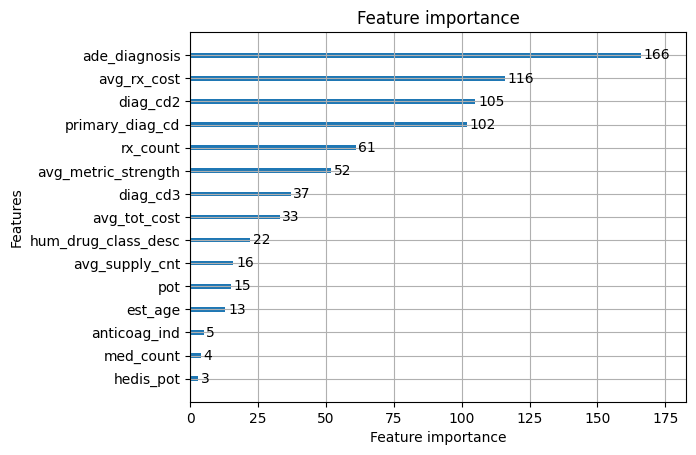

In [107]:
lgb.plot_importance(light_clf)

In [ ]:
# parameters = [{'boosting_type':['gdbt', 'dart'], 'n_estimators':[150,200,250,300], 'max_depth':[2,3,4], 'learning_rate':[0.05,0.1,0.5]}]

# search = GridSearchCV(lgb.LGBMClassifier(), param_grid=parameters, scoring='roc_auc')
# search.fit(x_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

In [ ]:
logistic = LogisticRegression(C=0.5, solver='newton-cg', penalty='l2', max_iter=3000)

logistic.fit(x_train, y_train)
y_pred = logistic.predict(x_test)
initial_pred['logistic'] = y_pred
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

AUC Score: 0.7613304093567251
Accuracy: 0.9335347432024169


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [ ]:
random_forest = RandomForestClassifier(max_depth=4, n_estimators=300, criterion='gini', random_state=42)

random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
initial_pred['forest'] = y_pred
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

AUC Score: 0.7107090643274854
Accuracy: 0.9335347432024169


In [ ]:
# parameters = [{'n_estimators':[150,200,250,300], 'max_depth':[3,4,5]}]

# search = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='roc_auc')
# search.fit(x_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

In [ ]:
cat_clf = CatBoostClassifier(depth=4, learning_rate=0.05)
cat_clf.fit(x_train, y_train)
#y_pred=clf.predict(x_test)
y_pred = cat_clf.predict(x_test)
initial_pred['cat'] = y_pred
#y_prob
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

0:	learn: 0.6100662	total: 47.1ms	remaining: 47s
1:	learn: 0.5301989	total: 47.9ms	remaining: 23.9s
2:	learn: 0.4874188	total: 48.5ms	remaining: 16.1s
3:	learn: 0.4346670	total: 49.2ms	remaining: 12.3s
4:	learn: 0.4014369	total: 50ms	remaining: 9.95s
5:	learn: 0.3720220	total: 50.8ms	remaining: 8.42s
6:	learn: 0.3570141	total: 51.6ms	remaining: 7.33s
7:	learn: 0.3337079	total: 53.3ms	remaining: 6.61s
8:	learn: 0.3161669	total: 54.3ms	remaining: 5.98s
9:	learn: 0.2999455	total: 55.1ms	remaining: 5.46s
10:	learn: 0.2791053	total: 56ms	remaining: 5.03s
11:	learn: 0.2693471	total: 57.3ms	remaining: 4.72s
12:	learn: 0.2568577	total: 58.4ms	remaining: 4.44s
13:	learn: 0.2420951	total: 59.5ms	remaining: 4.19s
14:	learn: 0.2302007	total: 60.7ms	remaining: 3.98s
15:	learn: 0.2222868	total: 64.3ms	remaining: 3.96s
16:	learn: 0.2129535	total: 65.1ms	remaining: 3.77s
17:	learn: 0.2092899	total: 66.2ms	remaining: 3.61s
18:	learn: 0.2003128	total: 68ms	remaining: 3.51s
19:	learn: 0.1941348	total: 70

In [ ]:
# parameters = [{'learning_rate':[0.05,0.1,0.5], 'depth':[2,3,4]}]

# search = GridSearchCV(CatBoostClassifier(), param_grid=parameters, scoring='roc_auc')
# search.fit(x_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

In [ ]:
QDA = QuadraticDiscriminantAnalysis()

QDA.fit(x_train, y_train)
y_pred = QDA.predict(x_test)
initial_pred['qda'] = y_pred
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

AUC Score: 0.7605994152046784
Accuracy: 0.7462235649546828


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
initial_pred

,ada,xgb,light,logistic,forest,cat,qda
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,0
327,0,0,0,0,0,0,0
328,0,0,0,0,0,0,0
329,0,0,0,0,0,0,0


In [ ]:
cv = StratifiedKFold(n_splits = 10,
                    shuffle = True,
                    random_state = 42)

meta_model = LogisticRegression(solver='newton-cholesky', max_iter=2000, C=2)
score_list, accuracy_list = [], []

for i, (train_val, test_val) in enumerate(cv.split(initial_pred,y_test)):
    X_learn, X_see = initial_pred.iloc[train_val], initial_pred.iloc[test_val]
    y_learn, y_see = y_test.iloc[train_val], y_test.iloc[test_val]

    meta_model.fit(X_learn, y_learn)

    y_pred = meta_model.predict_proba(X_see)[:,1]
    score = roc_auc_score(y_see, y_pred)
    score_list.append(score)
    y_pred = meta_model.predict(X_see)
    accuracy_list.append(metrics.accuracy_score(y_see, y_pred))

    print(f"Fold {i+1} AUC Score: {score:.5f}")

print('Average AUC Score: ', sum(score_list) / len(score_list))
print("Accuracy: ",sum(accuracy_list) / len(accuracy_list))

Fold 1 AUC Score: 1.00000
Fold 2 AUC Score: 1.00000
Fold 3 AUC Score: 0.73387
Fold 4 AUC Score: 0.98387
Fold 5 AUC Score: 0.78333
Fold 6 AUC Score: 0.93333
Fold 7 AUC Score: 0.70556
Fold 8 AUC Score: 0.96111
Fold 9 AUC Score: 0.97778
Fold 10 AUC Score: 0.51111
Average AUC Score:  0.8589964157706094
Accuracy:  0.9275401069518718


In [ ]:
# parameters = [{'C':[1,1.5,2], 'solver':['newton-cholesky', 'lbfgs'], 'max_iter':[1000,2000,3000]}]

# search = GridSearchCV(LogisticRegression(), param_grid=parameters, scoring='roc_auc')
# search.fit(initial_pred, y_test)

# print("Best parameters set found on development set:")
# print()
# print(search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search.cv_results_['mean_test_score']
# stds = search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean, std * 2, params))

## **Apply model**

In [ ]:
lazy_people_train[lazy_people_train['ground_truth']==1]

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,...,avg_supply_cnt,avg_rx_cost,avg_tot_cost,avg_metric_strength,generic_ind,maint_ind,hum_drug_class_desc,specialty_ind,rx_count,ground_truth
211,1078555806,1078555806-TAGRISSO-1,2019-11-11T00:00:00.000+0000,2019-12-11,1,3.0,68.0,F,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
729,1100138510,1100138510-TAGRISSO-1,2020-11-02T00:00:00.000+0000,2020-12-02,1,4.0,66.0,F,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [ ]:
lazy_people_train.cms_low_income_ind.sum()

10.0

In [ ]:
# x_holdout = val_df
# x_holdout.loc[:, x_holdout.dtypes == 'object'] =\
#     x_holdout.select_dtypes(['object'])\
#     .apply(lambda x: x.astype('category'))

In [ ]:
prob = light_clf.predict_proba(val_df)
score = pd.DataFrame(prob[:,1]).reset_index()
id = pd.DataFrame(patient_id).reset_index()

result = pd.concat([id,score],axis=1)
result.drop(columns = 'index',inplace = True)
result.rename(columns = {0:'score'}, inplace = True)

In [ ]:
lazy = pd.DataFrame(lazy_people_val).reset_index()
lazy['score'] = 0
lazy = lazy[['id','score']]

In [ ]:
result = pd.concat([result,lazy],axis=0)
result["RANK"] = result["score"].rank(ascending=False)

# sorting w.r.t name column
result.sort_values("score", inplace = True, ascending=False)
result.rename(columns={'id': 'ID', 'score': 'SCORE'}, inplace=True)
result["RANK"] = result["RANK"].astype(int)

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 258 to 83
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      420 non-null    int64  
 1   SCORE   420 non-null    float64
 2   RANK    420 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 13.1 KB


In [ ]:
result.to_csv('2023CaseCompetition_Hao_Huang_20231006.csv')